# SimFin Tutorial 03 - Growth & Returns

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"We shall fight the oppressors for your right to have babies, brother ... sister, sorry. What's the point of fighting for his right to have babies, when he can't have babies?! It is symbolic of our struggle against oppression! No, it's symbolic of his struggle against reality ..." &ndash; [Monty Python's Life of Brian](https://www.youtube.com/watch?v=PObBA2wH5l0)

## Introduction

Another common operation on financial data is to calculate changes over time, such as stock-returns and sales-growth. This tutorial first discusses Pandas' built-in functionality for doing this, but it does not seem to work so well for our data and purposes. We then introduce SimFin's helper-function `sf.rel_change` and demonstrates its features for calculating various kinds of stock-returns and growth-rates.

If you know a better way of calculating this using Pandas' built-in functionality, then we are very interested in hearing it.

It is assumed you are already familiar with Tutorial 01 on the basics of SimFin before you read this tutorial.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

## Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Load Datasets

In these examples, we will use the datasets for annual and quarterly Income Statements, as well as daily Share-Prices, all for USA.

In [6]:
%%time
# Data for USA.
market = 'us'

# Annual Income Statements.
df_income_ann = sf.load_income(variant='annual', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)

# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)

Dataset "us-income-annual" on disk (9 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (28 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 16 s, sys: 1.16 s, total: 17.1 s
Wall time: 15.7 s


Select a subset of the tickers and data-columns we are interested in:

In [7]:
tickers = ['AAPL', 'AMZN', 'MSFT']
df_income_ann = df_income_ann.loc[tickers, [REVENUE, NET_INCOME]].copy()
df_income_qrt = df_income_qrt.loc[tickers, [REVENUE, NET_INCOME]].copy()
df_prices = df_prices.loc[tickers, [CLOSE, ADJ_CLOSE]].copy()

In [8]:
df_income_ann.head()

Revenue   Net Income
Ticker Report Date                           
AAPL   2008-09-30   3.749100e+10   6119000000
       2009-09-30   4.290500e+10   8235000000
       2010-09-30   6.522500e+10  14013000000
       2011-09-30   1.082490e+11  25922000000
       2012-09-30   1.565080e+11  41733000000

In [9]:
df_income_qrt.head()

Revenue  Net Income
Ticker Report Date                          
AAPL   2009-06-30   9.734000e+09  1828000000
       2009-09-30   1.220700e+10  2532000000
       2009-12-31   1.568300e+10  3378000000
       2010-03-31   1.349900e+10  3074000000
       2010-06-30   1.570000e+10  3253000000

In [10]:
df_prices.head()

Close  Adj. Close
Ticker Date                           
AAPL   2007-01-03  11.9714       10.42
       2007-01-04  12.2371       10.65
       2007-01-05  12.1500       10.57
       2007-01-08  12.2100       10.62
       2007-01-09  13.2243       11.51

## Pandas Functions

Pandas has a lot of functionality for indexing DataFrames by time and date, shifting a DataFrame backwards or forwards in time, and calculating percentage changes over time. Unfortunately, these aspects of Pandas are poorly documented, so it is unclear exactly how they are supposed to work and what their short-comings are. So we will have to do some detective-work to try and figure out how this works in Pandas, and whether we can use it for our purposes.

Consider the first rows of the share-prices for ticker MSFT:

In [11]:
df = df_prices.loc['MSFT']['2007-01-03':]
df.head()

,Close,Adj. Close
Date,,
2007-01-03,29.86,22.25
2007-01-04,29.81,22.21
2007-01-05,29.64,22.08
2007-01-08,29.93,22.30
2007-01-09,29.96,22.32


The Pandas `shift` function moves the data forwards or backwards. When using the argument `periods` the data is moved in whole steps regardless of the index-dates in the DataFrame. For example, this moves the data one step forward:

In [12]:
df.shift(periods=1).head()

,Close,Adj. Close
Date,,
2007-01-03,NaN,NaN
2007-01-04,29.86,22.25
2007-01-05,29.81,22.21
2007-01-08,29.64,22.08
2007-01-09,29.93,22.30


When we perform arithmetic operations with the original and shifted DataFrames, they are first aligned by the index-dates. This allows us to calculate relative changes over time.

Let us explain what happens if we calculate `df/df.shift(periods=1)`. For the date 2007-01-04 the original Close value was 29.81, and for the preceding date 2007-01-03 the original Close value was 29.86. When we shift the DataFrame one step forward, the Close value from 2007-01-03 is moved to the following day 2007-01-04. We then divide the original Close value on 2007-01-04 which was 29.81, by the shifted Close value 29.86 that was originally at the preceding day 2007-01-03 but is now located at 2007-01-04 in the shifted DataFrame, so the result is a value of 29.81 / 29.86 = 0.998326 on 2007-01-04.

This is perhaps a bit abstract and can be difficult to understand, so it is recommended that you play around with the `shift` operator, to understand how it moves the data forwards and backwards.

Note that the first row in the DataFrame is NaN (short for "Not-a-Number"), because the arithemetic operation is trying to use data from the preceding time-step which does not exist in the DataFrame, so the result of the arithmetic operation for that row is NaN.

In [13]:
(df / df.shift(1)).head()

,Close,Adj. Close
Date,,
2007-01-03,NaN,NaN
2007-01-04,0.998326,0.998202
2007-01-05,0.994297,0.994147
2007-01-08,1.009784,1.009964
2007-01-09,1.001002,1.000897


Pandas has a built-in function for calculating the relative change in a time-series, so we don't have to shift the DataFrame ourselves. The function's name is `pct_change` which is somewhat misleading, because it actually calculates the relative change instead of the percentage change. It calculates the relative change from the previous time-step $t-periods$ until the current time-step $t$ using this formula:

$$
    pct\_change_t = \frac{data_t}{data_{t-periods}} - 1
$$

For example, we can calculate the relative change of the share-prices:

In [14]:
df.pct_change(periods=1).head()

,Close,Adj. Close
Date,,
2007-01-03,NaN,NaN
2007-01-04,-0.001674,-0.001798
2007-01-05,-0.005703,-0.005853
2007-01-08,0.009784,0.009964
2007-01-09,0.001002,0.000897


We can check that the result of the `pct_change` function and our calculation using the manually shifted DataFrame, is exactly the same if we also subtract 1:

In [15]:
# Relative change using manually shifted data.
df1 = df / df.shift(periods=1) - 1

# Relative change using Pandas' pct_change function.
df2 = df.pct_change(periods=1)

# Difference.
(df1 - df2).head()

,Close,Adj. Close
Date,,
2007-01-03,NaN,NaN
2007-01-04,0.0,0.0
2007-01-05,0.0,0.0
2007-01-08,0.0,0.0
2007-01-09,0.0,0.0


What if we want to shift the share-prices one year to calculate the 1-year returns? Most years have 365 days, except for every 4th year which is a leap-year that has 366 days. So on average a year has 365.25 days. We cannot call `df.shift(periods=365.25)` because the number of periods must be an integer.

Furthermore, there aren't 365 trading- or business-days in a normal year, because the stock-markets are not open during weekends and holidays.

Using the share-prices for ticker MSFT again, we can count the average number of trading-days in the 12 years between 2007 and 2018 (both inclusive), which is about 251.67 trading-days per year.

In [16]:
len(df['2007':'2018'])/12

251.66666666666666

We can also plot a histogram of the number of trading-days per year between 2007 and 2018 (both inclusive), where we can see that about half of the years had 252 trading days:

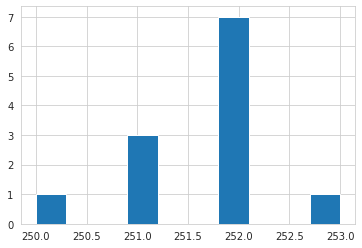

In [17]:
df2 = df['2007':'2018']
df2.groupby(df2.index.year).apply(lambda x: len(x)).hist()

If we use the average of 251.67 trading-days per year, then in order to shift the DataFrame with share-prices one year, we need to shift it 251.67 periods or steps. In practice we round this up to the nearest integer 252. But if we want to calculate the number of periods for multiple years, then it is best to do the rounding to the nearest integer at the end:

In [18]:
int(round(251.67 * 3))

755

If instead we had used the rounded number 252 we would get a small error, which grows bigger for more years:

In [19]:
252 * 3

756

But even so, we can still get a small drift in the dates, because 251.67 is an average number and some years will have a different number of trading-days per year.

For example, if we calculate the 5-year changes, we can see that it has drifted 3 time-steps. A few days of drift for a 5-year period is typically deemed acceptable when analyzing long-term stock returns, as it will most likely have a negligible impact on the statistics.

In [20]:
years = 5
periods = int(round(251.67 * years))
df.pct_change(periods=periods).dropna().head()

,Close,Adj. Close
Date,,
2011-12-29,-0.128600,-0.035506
2011-12-30,-0.129151,-0.036020
2012-01-03,-0.096997,0.000000
2012-01-04,-0.084531,0.013453
2012-01-05,-0.076101,0.022849


### Pandas DateOffset

Pandas also provides more sophisticated ways of shifting DataFrames. One way is to use `pd.DateOffset`. Unfortunately, Pandas' [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.tseries.offsets.DateOffset.html) is brief and unclear, so we have to partially guess how it is supposed to work. If we try and calculate 1-year returns on the DataFrame with share-prices for ticker MSFT, then we get an exception:

In [21]:
try:
    df.pct_change(freq=pd.DateOffset(years=1))
except Exception as e:
    print(e)

cannot reindex from a duplicate axis


Pandas also allows a [string alias](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) as the date-offset. For example, we can try 'BY' for Business Year, but we still get an exception:

In [22]:
try:
    df.pct_change(freq='BY')
except Exception as e:
    print(e)

cannot reindex from a duplicate axis


The problem in both cases, seems to be that leap-years cause duplicate entries in the index, because 29th February in a leap-year is shifted to 28th February in the following year, but there is already another row with that date:

In [23]:
# Shift the DataFrame.
df_shifted = df.shift(freq=pd.DateOffset(years=1)).dropna()

# Boolean mask for rows with duplicate index-values.
mask = df_shifted.index.duplicated(keep=False)

# Show the duplicate rows.
df_shifted.loc[mask]

,Close,Adj. Close
Date,,
2009-02-28,27.9300,21.17
2009-02-28,27.1999,20.62
2013-02-28,31.8700,26.46
2013-02-28,31.7400,26.35


Another option is to specify a 365-day period instead of a 1-year period:

In [24]:
# Relative change over 365-days.
df_change = df.pct_change(freq=pd.DateOffset(days=365))

# Remove leading NaN.
start_idx = df_change.first_valid_index()
df_change = df_change.loc[start_idx:]

This does not raise an exception, but it has introduced a lot of NaN values in the data, for example around the problematic leap-year dates in 2009 and 2013:

In [25]:
df_change['2009-02-26':'2009-03-04']

,Close,Adj. Close
Date,,
2009-02-26,-0.418967,-0.406162
2009-02-27,-0.421769,-0.409069
2009-03-02,NaN,NaN
2009-03-03,-0.411634,-0.398827
2009-03-04,-0.415730,-0.402678


In [26]:
df_change['2013-02-28':'2013-03-06']

,Close,Adj. Close
Date,,
2013-02-28,-0.124134,-0.097533
2013-03-01,-0.134407,-0.108169
2013-03-04,NaN,NaN
2013-03-05,-0.108491,-0.081439
2013-03-06,-0.109808,-0.082824


This has created hundreds of rows with NaN values, so this clearly did not work either:

In [27]:
mask = df_change.isnull().any(axis=1)
df_change[mask]

,Close,Adj. Close
Date,,
2008-01-07,NaN,NaN
2008-01-14,NaN,NaN
2008-01-15,NaN,NaN
2008-01-28,NaN,NaN
2008-02-04,NaN,NaN
...,...,...
2019-11-22,NaN,NaN
2019-11-25,NaN,NaN
2019-12-02,NaN,NaN


Pandas has several other ways of representing and manipulating dates, but none of them seem to work for our purposes. This is strange because Pandas was originally made for financial time-series. So I wonder if the Pandas developers never use investment periods of a year or more - or perhaps I have failed to understand how Pandas is supposed to do this. This is not easy to find out, because Pandas' documentation is brief and incomplete.

## SimFin Helper-Function

SimFin provides a helper-function named `sf.rel_change` that is specialized for calculating changes over time for this kind of financial data.

The function assumes that the DataFrame is ordered ascendingly by the index-dates, and that the DataFrame is complete in the sense that data is present for all time-steps of the given frequency. The function does not check this, but the SimFin database ensures that the quarterly and annual financial data such as Income Statements and Balance Sheets are all complete without any missing reports. If you are using other data-sources, then you must ensure that yourself before using this function.

Furthermore, the function supports both Pandas DataFrames and Series, as well as `DatetimeIndex` or `MultiIndex` with 2 indices, one of which is a `DatetimeIndex` and the other is e.g. TICKER or SIMFIN_ID.

The function has a number of useful features, and all of this makes it easy to use on a wide variety of financial data, as we will demonstrate now.

### Stock Returns

Let us start with a basic example of calculating the daily changes in stock-prices for ticker MSFT. We set the argument `freq='bdays'` to indicate the DataFrame contains data for all business-days (roughly 252 data-points per year, as explained above). Pandas has functionality to detect the frequency of a DataFrame, but it doesn't seem to work properly, so we need to specify it manually.

We then set the arguments for the time-interval we want, in this case we just set `bdays=1` which means we want the relative change between successive time-steps, because the DataFrame has the same frequency.

Finally we set the arg `future=False` to indicate that we want the **past** change between the previous day $t-1$ and the current day $t$ so the function calculates `df_result[t] = df[t]/df[t-1] - 1`.  Note that this calculates the exact same as `df.pct_change(periods=1)` shown further above.

In [28]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              bdays=1, future=False).head()

,Close,Adj. Close
Date,,
2007-01-03,NaN,NaN
2007-01-04,-0.001674,-0.001798
2007-01-05,-0.005703,-0.005853
2007-01-08,0.009784,0.009964
2007-01-09,0.001002,0.000897


Let us now try and change a single argument by setting `future=True` instead, to indicate that we want the change between the **future** time-step $t+1$ and the current time-step $t$, so the function calculates `df_result[t] = df[t+1]/df[t] - 1`. As you can see, this is effectively the same DataFrame as above, that has just been shifted one step backwards - and that is indeed how the helper-function implements it.

In [29]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              bdays=1, future=True).head()

,Close,Adj. Close
Date,,
2007-01-03,-0.001674,-0.001798
2007-01-04,-0.005703,-0.005853
2007-01-05,0.009784,0.009964
2007-01-08,0.001002,0.000897
2007-01-09,-0.010013,-0.009857


We can also use an arbitrary time-interval that is a multiple of the DataFrame's frequency. A simple example is to get the future change in stock-prices for 1-year intervals, so we effectively calculate `df_result[t] = df[t+1 year]/df[t] - 1`:

In [30]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              years=1, future=True).dropna().head()

,Close,Adj. Close
Date,,
2007-01-03,0.184528,0.200449
2007-01-04,0.153304,0.168843
2007-01-05,0.167679,0.183424
2007-01-08,0.117608,0.132735
2007-01-09,0.149533,0.165323


We can also combine several arguments for the time-interval. For example, let us say we want 3 business-days plus 1 year, so we effectively calculate `df_result[t] = df[t+1 year+3 bdays]/df[t] - 1`:

In [31]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              bdays=3, years=1, future=True).dropna().head()

,Close,Adj. Close
Date,,
2007-01-03,0.120228,0.135281
2007-01-04,0.155317,0.171094
2007-01-05,0.158232,0.173913
2007-01-08,0.132977,0.148430
2007-01-09,0.147864,0.163530


For periods of several years, it is often useful to calculate the annualized returns. For example, if we want the past annualized returns for 3-year investment periods, we are effectively calculating `df_result[t] = (df[t]/df[t-3 years]) ** (1/3) - 1`. Note that there is a small drift of a few days, but that is deemed acceptable for periods of 3 years, as we discussed further above.

In [32]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              years=3, future=False, annualized=True).dropna().head()

,Close,Adj. Close
Date,,
2009-12-31,0.006874,0.025416
2010-01-04,0.012588,0.031280
2010-01-05,0.014630,0.033441
2010-01-06,0.009269,0.027914
2010-01-07,0.005444,0.024058


Once again, we can combine different arguments for the time-interval, and the function automatically calculates the correct annualized return for that time-interval, but the formula is too long and complicated to write here, so we just demonstrate the function:

In [33]:
sf.rel_change(df=df_prices.loc['MSFT'], freq='bdays',
              bdays=2, weeks=3, months=3, years=3,
              future=False, annualized=True).dropna().head()

,Close,Adj. Close
Date,,
2010-04-27,0.009842,0.028099
2010-04-28,0.010995,0.029293
2010-04-29,0.013659,0.032135
2010-04-30,0.006057,0.024341
2010-05-03,0.008971,0.027252


In the examples above we only used a DataFrame with a single stock, but all the demonstrated features also work seamlessly for DataFrames with multiple stocks:

In [34]:
sf.rel_change(df=df_prices, freq='bdays',
              weeks=1, months=2, years=3,
              future=False, annualized=True).dropna()

Close  Adj. Close
Ticker Date                            
AAPL   2010-03-11  0.364285    0.364139
       2010-03-12  0.356989    0.356793
       2010-03-15  0.354814    0.354833
       2010-03-16  0.353878    0.354048
       2010-03-17  0.319785    0.319687
...                     ...         ...
MSFT   2019-12-05  0.346979    0.372822
       2019-12-06  0.356728    0.382734
       2019-12-09  0.354154    0.380097
       2019-12-10  0.354838    0.380798
       2019-12-11  0.357777    0.383798

[7371 rows x 2 columns]

### Share-Price : Close vs. Adj. Close

It is important to understand the difference between the 'Close' and 'Adj. Close' share-price, which was also explained in Tutorial 01.

The Close share-price is only adjusted for stock-splits, while the Adj. Close share-price is adjusted for both stock-splits and dividends. This means the Close share-price should be used when calculating valuation ratios such as P/Sales or P/E (which is demonstrated in Tutorial 04), while the Adj. Close should be used for calculating stock-returns.

For daily stock-returns the Close and Adj. Close are identical, except on the days where dividends have been paid on the stock. The Adj. Close is adjusted for the dividend by assuming it is immediately reinvested in the stock, without having to pay any dividend-taxes, trading commissions, etc. This is also known as the Total Return.

For longer time-intervals of one or more years, it becomes increasingly important to use the Adj. Close when calculating stock-returns, so as to include the dividends. Although some stocks pay little or no dividends, for other stocks the dividend might be a significant part of the annual returns.

SimFin's keywords for the data-columns provide aliases that reflect this relationship so that `SHARE_PRICE == CLOSE == 'Close'` and `TOTAL_RETURN == ADJ_CLOSE == 'Adj. Close'`. So you just need to remember always to use the keyword `SHARE_PRICE` when calculating valuation ratios such as P/E and P/Sales, and use the keyword `TOTAL_RETURN` when calculating stock-returns.

For example, we can calculate the future 5-year annualized returns from each stock's Total Return as follows:

In [35]:
sf.rel_change(df=df_prices[TOTAL_RETURN], freq='bdays',
              years=5, future=True, annualized=True).dropna()

Ticker  Date      
AAPL    2007-01-03    0.370454
        2007-01-04    0.364427
        2007-01-05    0.370643
        2007-01-08    0.370793
        2007-01-09    0.351933
                        ...   
MSFT    2014-12-05    0.281061
        2014-12-08    0.288033
        2014-12-09    0.287912
        2014-12-10    0.291291
        2014-12-11    0.290795
Name: Adj. Close, Length: 6003, dtype: float64

### Growth

The same helper-function can be used to calculate growth-rates for quarterly or annual data. Let us first consider the quarterly Income Statements for ticker MSFT:

In [36]:
df_income_qrt.loc['MSFT'].head(8)

,Revenue,Net Income
Report Date,,
2009-06-30,1.309900e+10,3045000000
2009-09-30,1.292000e+10,3574000000
2009-12-31,1.902200e+10,6662000000
2010-03-31,1.450300e+10,4006000000
2010-06-30,1.603900e+10,4518000000
2010-09-30,1.619500e+10,5410000000
2010-12-31,1.995300e+10,6634000000
2011-03-31,1.642800e+10,5232000000


We can calculate the quarterly growth-rate using `sf.rel_change` with the argument `freq='q'` to indicate the DataFrame contains data with quarterly frequency, and `quarters=1` if we want to calculate the relative change over 1 quarter, and `future=False` to get the past growth from the previous to the current quarter:

In [37]:
sf.rel_change(df=df_income_qrt.loc['MSFT'], freq='q',
              quarters=1, future=False).head()

,Revenue,Net Income
Report Date,,
2009-06-30,NaN,NaN
2009-09-30,-0.013665,0.173727
2009-12-31,0.472291,0.864018
2010-03-31,-0.237567,-0.398679
2010-06-30,0.105909,0.127808


We can also use a time-interval of 1 year with the argument `years=1`, and the function automatically converts it into 4 quarters:

In [38]:
sf.rel_change(df=df_income_qrt.loc['MSFT'], freq='q',
              years=1, future=False).head(8)

,Revenue,Net Income
Report Date,,
2009-06-30,NaN,NaN
2009-09-30,NaN,NaN
2009-12-31,NaN,NaN
2010-03-31,NaN,NaN
2010-06-30,0.224445,0.483744
2010-09-30,0.253483,0.513710
2010-12-31,0.048943,-0.004203
2011-03-31,0.132731,0.306041


If we set a time-interval that is not a multiple of the DataFrame's frequency, which is quarterly in this case, then it is automatically rounded to the nearest multiple of the frequency. For example, if we use a time-interval of 2 months and 1 year, then it is rounded to 5 quarters:

In [39]:
sf.rel_change(df=df_income_qrt.loc['MSFT'], freq='q',
              months=2, years=1, future=False).head(8)

,Revenue,Net Income
Report Date,,
2009-06-30,NaN,NaN
2009-09-30,NaN,NaN
2009-12-31,NaN,NaN
2010-03-31,NaN,NaN
2010-06-30,NaN,NaN
2010-09-30,0.236354,0.776683
2010-12-31,0.544350,0.856184
2011-03-31,-0.136368,-0.214650


When the time-interval is more than a year, it is often useful to consider the annualized growth-rate, which is done by setting the argument `annualized=True`. For example, let us calculate the past 3-year annualized growth-rates:

In [40]:
sf.rel_change(df=df_income_qrt.loc['MSFT'], freq='q',
              years=3, future=False, annualized=True).dropna().head()

,Revenue,Net Income
Report Date,,
2012-09-30,0.074051,0.077097
2012-12-31,0.040952,-0.014468
2013-03-31,0.122073,0.147628
2013-06-30,0.074475,0.031948
2013-09-30,0.045900,-0.010334


We can do the exact same calculations on DataFrames with multiple stocks:

In [41]:
sf.rel_change(df=df_income_qrt, freq='q',
              years=3, future=False, annualized=True).dropna()

Revenue  Net Income
Ticker Report Date                      
AAPL   2012-06-30   0.532336    0.690038
       2012-09-30   0.433599    0.480888
       2012-12-31   0.514797    0.570220
       2013-03-31   0.478217    0.458997
       2013-06-30   0.310346    0.284858
...                      ...         ...
MSFT   2018-09-30   0.125876    0.216459
       2018-12-31   0.109168    0.188303
       2019-03-31   0.141913    0.328619
       2019-06-30   0.084306    0.243209
       2019-09-30   0.146602    0.235129

[75 rows x 2 columns]

### Invalid Data

Some data causes the calculations for the relative change to become mathematically invalid. One example is if some values are zero, so the relative change causes division by zero, which creates a value of infinity in Pandas.

Another example is when one number is negative and the other is positive, so the fraction of the two numbers is negative. This causes a problem when calculating annualized changes for multiple years.

For example, consider the following which calculates the annualized change from a value of 456 to -123 over a 3-year period. The result is a complex number here, but in the Pandas DataFrames returned by `sf.rel_change` this would be a NaN ("Not-a-Number"):

In [42]:
(-123 / 456) ** (1/3) - 1

(-0.6769398225681011+0.559556641214265j)

To demonstrate this, consider the annual Income Statements for ticker AMZN, and note how the Net Income is negative in several rows:

In [43]:
df_income_ann.loc['AMZN']

,Revenue,Net Income
Report Date,,
2008-12-31,1.916600e+10,645000000
2009-12-31,2.450900e+10,902000000
2010-12-31,3.420400e+10,1152000000
2011-12-31,4.807700e+10,631000000
2012-12-31,6.109300e+10,-39000000
2013-12-31,7.445200e+10,274000000
2014-12-31,8.898800e+10,-241000000
2015-12-31,1.070060e+11,596000000
2016-12-31,1.359870e+11,2371000000


We can calculate the relative change without problems:

In [44]:
sf.rel_change(df=df_income_ann.loc['AMZN'], freq='y',
              years=3, future=False)

,Revenue,Net Income
Report Date,,
2008-12-31,NaN,NaN
2009-12-31,NaN,NaN
2010-12-31,NaN,NaN
2011-12-31,1.508452,-0.021705
2012-12-31,1.492676,-1.043237
2013-12-31,1.176704,-0.762153
2014-12-31,0.850947,-1.381933
2015-12-31,0.751526,-16.282051
2016-12-31,0.826506,7.653285


But if we try and calculate the annualized change, then the rows with negative Net Income become NaN ("Not-a-Number"):

In [45]:
sf.rel_change(df=df_income_ann.loc['AMZN'], freq='y',
              years=3, future=False, annualized=True)

,Revenue,Net Income
Report Date,,
2008-12-31,NaN,NaN
2009-12-31,NaN,NaN
2010-12-31,NaN,NaN
2011-12-31,0.358737,-0.007288
2012-12-31,0.355882,NaN
2013-12-31,0.295985,-0.380417
2014-12-31,0.227811,NaN
2015-12-31,0.205421,NaN
2016-12-31,0.222382,1.053022


The function `sf.rel_change` currently does not do any additional processing to help with such invalid data, so you must do any pre- and post-processing of the data yourself.

### Column Names

In all the example above, the column-names were the same after calculating the relative changes. We can change the column-names by passing the argument `new_names` to the `sf.rel_change` function. This argument is passed directly to the Pandas `rename` function and therefore accepts the same arguments.

For example, we can use a dict to map from the old to new names:

In [46]:
# New column-names.
SHARE_PRICE_3Y = 'Share Price 3-Year'
TOTAL_RETURN_3Y = 'Total Return 3-Year'

# Dict mapping old to new column-names.
new_names = {CLOSE: SHARE_PRICE_3Y,
             ADJ_CLOSE: TOTAL_RETURN_3Y}

# Calculate the annualized 3-year changes and rename columns.
sf.rel_change(df=df_prices, freq='bdays',
              years=3, future=False, annualized=True,
              new_names=new_names).dropna()

Share Price 3-Year  Total Return 3-Year
Ticker Date                                               
AAPL   2009-12-31            0.359871             0.359641
       2010-01-04            0.356921             0.356789
       2010-01-05            0.360938             0.360885
       2010-01-06            0.351463             0.351568
       2010-01-07            0.315176             0.314955
...                               ...                  ...
MSFT   2019-12-05            0.355349             0.379921
       2019-12-06            0.362851             0.387593
       2019-12-09            0.351098             0.375590
       2019-12-10            0.353064             0.377583
       2019-12-11            0.347731             0.372150

[7512 rows x 2 columns]

Another way of changing the column-names is to use a lambda-function. This is useful if you want to quickly rename all the columns in the same way, and don't need to address them later, in which case you would have to use a string such as 'Close 3-Year Ann. Chg.' instead of keywords like SHARE_PRICE_3Y.

In [47]:
# Lambda function for changing column-names.
new_names = lambda old_name: old_name + ' 3-Year Ann. Chg.'

# Calculate the annualized 3-year changes and rename columns.
sf.rel_change(df=df_prices, freq='bdays',
              years=3, future=False, annualized=True,
              new_names=new_names).dropna()

Close 3-Year Ann. Chg.  Adj. Close 3-Year Ann. Chg.
Ticker Date                                                           
AAPL   2009-12-31                0.359871                     0.359641
       2010-01-04                0.356921                     0.356789
       2010-01-05                0.360938                     0.360885
       2010-01-06                0.351463                     0.351568
       2010-01-07                0.315176                     0.314955
...                                   ...                          ...
MSFT   2019-12-05                0.355349                     0.379921
       2019-12-06                0.362851                     0.387593
       2019-12-09                0.351098                     0.375590
       2019-12-10                0.353064                     0.377583
       2019-12-11                0.347731                     0.372150

[7512 rows x 2 columns]

### Plotting

If we want to plot the relative changes that we have calculated for a single stock, then it is quite easy because the function `sf.rel_change` returns a Pandas DataFrame that provides a `plot` function. For example, we can plot the 3-year annualized growth-rate for the Revenue and Net Income for the stock with ticker MSFT:

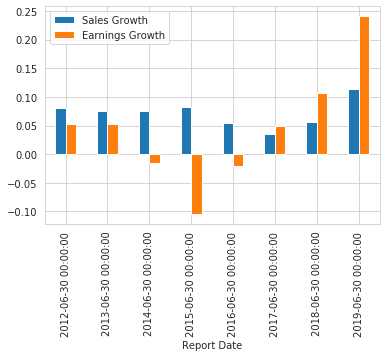

In [48]:
# New column-names.
SALES_GROWTH = 'Sales Growth'
EARNINGS_GROWTH = 'Earnings Growth'

# Dict mapping from old to new column-names.
new_names = {REVENUE: SALES_GROWTH,
             NET_INCOME: EARNINGS_GROWTH}

# Calculate annualized 3-year growth-rates and rename columns.
sf.rel_change(df=df_income_ann.loc['MSFT'], freq='y',
              years=3, future=False, annualized=True,
              new_names=new_names).dropna().plot(kind='bar')

If we want to make a single plot for multiple stocks, then we can use the Seaborn plotting package.

Text(0.5, 1.0, '3-Year Annualized Sales Growth')

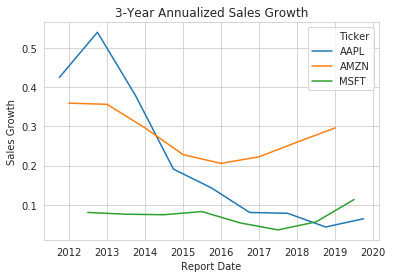

In [49]:
# Calculate annualized 3-year growth-rates.
df_growth = sf.rel_change(df=df_income_ann, freq='y',
                          years=3, future=False, annualized=True,
                          new_names=new_names)

# Remove rows where ALL items are NaN.
# This keeps the rows where e.g. the Revenue growth was valid,
# but the Net Income growth was invalid due to negative numbers.
df_growth = df_growth.dropna(how='all')

# Title of the plot.
title = '3-Year Annualized Sales Growth'

# Plot with connected lines.
sns.lineplot(x=REPORT_DATE, y=SALES_GROWTH, hue=TICKER,
            data=df_growth.reset_index()).set_title(title)

We would like to plot this as a bar-chart, but the x-axis looks bad:

Text(0.5, 1.0, '3-Year Annualized Sales Growth')

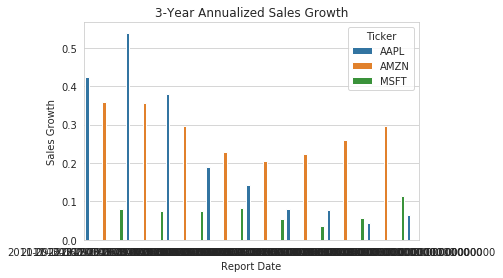

In [50]:
sns.barplot(x=REPORT_DATE, y=SALES_GROWTH, hue=TICKER,
            data=df_growth.reset_index()).set_title(title)

We can use the Fiscal Year as the index instead of the Report Date, to better align the x-axis in the bar-chart, but we removed that from the DataFrame above, so we need to reload the data and use Fiscal Year as the index:

In [51]:
# Load annual Income Statements and set the index.
df = sf.load_income(variant='annual', market='us',
                    index=[TICKER, FISCAL_YEAR])

# Select the tickers and columns we are interested in.
df = df.loc[tickers, [REVENUE, NET_INCOME]]

Dataset "us-income-annual" on disk (9 days old).
- Loading from disk ... Done!


We can then calculate the growth-rates and plot them in a bar-chart using Seaborn:

Text(0.5, 1.0, '3-Year Annualized Sales Growth')

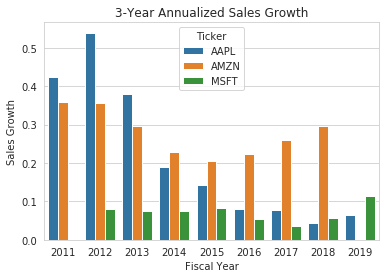

In [52]:
# Calculate annualized 3-year growth-rates.
df_growth = sf.rel_change(df=df, freq='y',
                          years=3, future=False, annualized=True,
                          new_names=new_names)

# Remove rows where ALL items are NaN.
# This keeps the rows where e.g. the Revenue growth was valid,
# but the Net Income growth was invalid due to negative numbers.
df_growth = df_growth.dropna(how='all')

# Plot bar-lines.
sns.barplot(x=FISCAL_YEAR, y=SALES_GROWTH, hue=TICKER,
            data=df_growth.reset_index()).set_title(title)

## Mean Log-Change

The simfin package provides another function `sf.mean_log_change` which is used to calculate the average change over many periods. This is useful for calculating the mean annualized return on a stock e.g. over all 1-3 year periods, so as to smoothen out the short-term volatility and get a less noisy estimate of the future return. We will use this in other tutorials to study the relation between predictor variables such as P/E ratios and average stock-returns over the following 1-3 years.

We will first show how the mathematical formulas are derived and then show how the function `sf.mean_log_change` is used on the data. The math gives the precise definition of what is being calculated, but if you understand the general idea then you can probably skip the math.

### Mathematical Derivation

Let us consider a time-series $x_t$ which is indexed by time-step $t$. This could e.g. be the Total Return time-series of a stock, which is the share-price with dividends reinvested immediately and without having to pay any taxes, so it is a tax-neutral measure of the total return to investors from dividends and changes in share-price.

We are then interested in the average change between the current time-step $t$ and all the future time-steps between $t + N$ and $t + M$, e.g. we could choose $N$ to be 1 year and $M$ to be 3 years, so we are interested in the change between the current time-step $t$ and all future time-steps between $t + 1\ Year$ and $t + 3\ Years$.

For each value $i$ between $N$ and $M$ we want to normalize the change between the current time-step $x_t$ and the future time-step $x_{t+i}$ so they are comparable for different choices of $i$, because there is a big difference in a 10% change that occurs over a single year, compared to a 10% change that occurs gradually over 3 years. An easy way of doing this normalization, is to use the Geometric Mean, which is the average cumulative change per step, in order to go from $x_t$ to $x_{t+i}$ in $i$ steps. In this case it is simply the $i$'th root of the overall change, which is calculated as follows:

$$
    Geometric\ Mean\ Change_{t, i} = \left( \frac{x_{t+i}}{x_t} \right) ^ {1/i}
$$

We can easily check that the Geometric Mean takes us from $x_t$ to $x_{t+i}$ in $i$ steps, by taking it to the $i$'th power:

$$
\left( Geometric\ Mean\ Change_{t, i} \right) ^ i
= \left[ \left( \frac{x_{t+i}}{x_t} \right) ^ {1/i} \right] ^ i 
= \frac{x_{t+i}}{x_t}
$$

If we wanted to calculate the Annualized Change instead, then we need to adjust for a factor $a$. For example, if we are using daily share-price data then $a$ would be roughly 252 because that's how many trading-days there typically are in a year. If we are using quarterly financial data, then $a$ would be 4 because that's how many quarters there are per year. The formula with this adjustment is only slightly different:

$$
    Annualized\ Change_{t, i} = \left( \frac{x_{t+i}}{x_t} \right) ^ {a/i}
$$

Now that we have normalized the changes from $x_t$ to $x_{t+i}$ for different choices of $i$, we want to take their average. Ideally we would like to calculate the following:

$$
    Mean\ Annualized\ Change_t = \frac{1}{M-N} \cdot \sum_{i=N}^{M} \left( \frac{x_{t+i}}{x_t} \right) ^ {a/i}
$$

This is easy enough to implement using for-loops, but it would be very slow in native Python code. Instead we want a formula that can be calculated efficiently using Pandas and Numpy's vectorized functions. So we use the logarithm to transform the formula into the following:

$$
Mean\ Log\ Change_t = \frac{1}{M-N} \cdot \sum_{i=N}^{M} \log \left[ \left( \frac{x_{t+i}}{x_t} \right) ^ {a/i} \right] \\
= \frac{1}{M-N} \cdot \sum_{i=N}^{M} (a/i) \cdot \left( \log(x_{t+i}) - \log(x_t) \right) \\
= \frac{1}{M-N} \cdot \left[ \sum_{i=N}^{M} (a/i) \cdot \log(x_{t+i}) - \log(x_t) \cdot \sum_{i=N}^{M} (a/i) \right] \\
$$

This formula may look weird and intimidating, but it is reasonably simple if we break it down. The hardest part of the formula is the following, which is a so-called *windowing* function, that takes the dot-product between a slice of the time-series from $x_{t+N}$ to $x_{t+M}$ and a vector of values $(a/i)$ where $i$ goes from $N$ to $M$:

$$
     \sum_{i=N}^{M} (a/i) \cdot \log(x_{t+i})
$$

If instead we are interested in the change from **past** time-steps $x_{t-i}$ to the current time-step $x_t$, then the formula becomes:

$$
Mean\ Log\ Change_t = \frac{1}{M-N} \cdot \sum_{i=N}^{M} \log \left[ \left( \frac{x_t}{x_{t-i}} \right) ^ {a/i} \right] \\
= \frac{1}{M-N} \cdot \sum_{i=N}^{M} (a/i) \cdot \left( \log(x_t) - \log(x_{t-i}) \right) \\
= \frac{1}{M-N} \cdot \left[ \log(x_t) \cdot \sum_{i=N}^{M} (a/i) - \sum_{i=N}^{M} (a/i) \cdot \log(x_{t-i}) \right] \\
$$

The vector of values $(a/i)$ can be pre-calculated for efficiency, as can its sum. The windowing can be calculated using the Pandas `rolling` operator. And we can handle DataFrames with multiple stocks by using the `groupby` operator. So altogether we can implement these log-transformed formulas quite efficiently using Pandas and Numpy's vectorized operators, instead of slow for-loops. But the implementation is a bit complicated and may be hard to understand without the mathematical derivation above.

### Future Mean-Log Annualized Stock Returns

Let us now try and use the function `sf.mean_log_change` to calculate and plot the mean-log annualized stock-returns for all 1-3 year periods. That is, we want to calculate the mean-log annualized changes between the current time-step: `df_prices[t]` and all future time-steps in the slice: `df_prices[t + 1 Year:t + 3 Years]`

Text(0.5, 1.0, 'Future 1-3 Years Mean-Log Ann. Total Return')

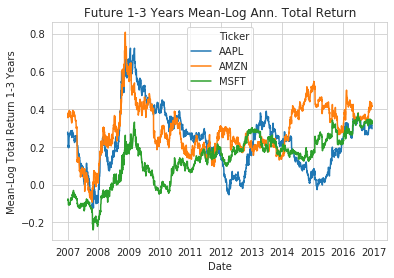

In [53]:
# New column-names.
SHARE_PRICE_1_3Y = 'Mean-Log Share-Price Return 1-3 Years'
TOTAL_RETURN_1_3Y = 'Mean-Log Total Return 1-3 Years'

# Dict mapping old to new column-names.
new_names_1_3y = {SHARE_PRICE: SHARE_PRICE_1_3Y,
                  TOTAL_RETURN: TOTAL_RETURN_1_3Y}

# Calculate the future mean-log annualized 1-3 year changes.
df_mean_chg = sf.mean_log_change(df=df_prices, freq='bdays',
                                 future=True, annualized=True,
                                 min_years=1, max_years=3,
                                 new_names=new_names_1_3y)

# Title of the plot.
title = 'Future 1-3 Years Mean-Log Ann. Total Return'

# Plot the result.
data = df_mean_chg.dropna().reset_index()
sns.lineplot(x=DATE, y=TOTAL_RETURN_1_3Y, hue=TICKER,
             data=data).set_title(title)

The simfin function actually uses the natural logarithm, which is almost linear for returns between $\pm 20\%$, but beyond that range it underestimates both the gains and losses compared to the non-log returns. But for practical purposes, you may often consider the mean-log changes to be roughly equivalent to the normal percentage changes.

For example, consider the mean-log Total Return on 15th November 2016 for ticker MSFT:

In [54]:
df_mean_chg.loc[('MSFT', '2016-11-15'), TOTAL_RETURN_1_3Y]

Ticker  Date      
MSFT    2016-11-15    0.337589
Name: Mean-Log Total Return 1-3 Years, dtype: float64

This value of about 0.34 is the mean-log annualized return for *all* periods starting on 2016-11-15 and ending somewhere between 2017-11-15 and 2019-11-15. So if you had bought the MSFT stock on 2016-11-15 and held it somewhere between 1 and 3 years, then on average, you would have made a log-return of 0.34 per year.

Because the log-transform underestimates the normal returns for values beyond $\pm 20\%$, the mean annualized return was probably around 40% for all the holding-periods starting on 2016-11-15 and ending somewhere between 2017-11-15 and 2019-11-15.

As will be shown in other tutorials, the mean-log stock-returns are very useful for studying the relation between predictor variables such as P/E ratios and future returns.

### Past Mean-Log Annualized Stock Returns

We can also calculate mean-log returns for the **past** instead of the future as we did above. For example, we may calculate the mean-log annualized change between all the **past** time-steps in the slice: `df_prices[t - 3 Years:t - 1 Year]` and the current time-step: `df_prices[t]`. This is done simply by changing the function's argument to `future=False`:

Text(0.5, 1.0, 'Past 1-3 Years Mean-Log Ann. Total Return')

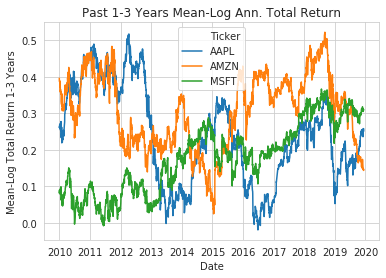

In [55]:
# Calculate the past annualized 1-3 year changes.
df_mean_chg = sf.mean_log_change(df=df_prices, freq='bdays',
                                 future=False, annualized=True,
                                 min_years=1, max_years=3,
                                 new_names=new_names_1_3y)

# Title of the plot.
title = 'Past 1-3 Years Mean-Log Ann. Total Return'

# Plot the result.
data = df_mean_chg.dropna().reset_index()
sns.lineplot(x=DATE, y=TOTAL_RETURN_1_3Y, hue=TICKER,
             data=data).set_title(title)

For example, consider the mean-log Total Return on 15th November 2019 for ticker MSFT:

In [56]:
df_mean_chg.loc[('MSFT', '2019-11-15'), TOTAL_RETURN_1_3Y]

Ticker  Date      
MSFT    2019-11-15    0.312211
Name: Mean-Log Total Return 1-3 Years, dtype: float64

This value of about 0.31 is the mean-log annualized return for *all* 1-3 year periods ending on 2019-11-15 that started somewhere between 2016-11-15 and 2018-11-15. So if you had bought the MSFT stock somewhere between 2016-11-15 and 2018-11-15 and sold it on 2019-11-15, then on average, you would have made a log-return of 0.31 per year. Because the log-transform underestimates the normal returns for values beyond $\pm 20\%$, the mean annualized return was probably around 36%.

### Geometric Mean Daily Stock-Returns

The annualized returns are particularly useful for longer periods of several years, but for shorter periods the annualization formula can produce extreme values. So it is sometimes more useful to calculate the geometric mean, based on the frequency of the original data.

For example, when we are using daily share-price data, the geometric mean tells us how much the daily return should be, in order to compound into the average return that was observed over an entire period.

The following example shows the mean-log geometric-mean for all future stock-returns between 1-3 months. We switch from Annualization to Geometric Mean simply by setting the function's argument `annualized=False`:

Text(0.5, 1.0, 'Future 1-3 Months Mean-Log Total Return')

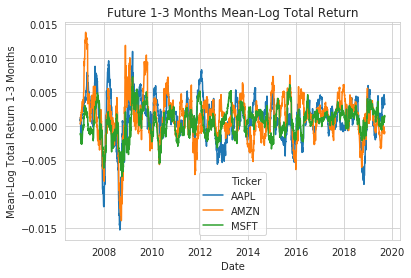

In [57]:
# New column-names.
SHARE_PRICE_1_3M = 'Mean-Log Share-Price Return 1-3 Months'
TOTAL_RETURN_1_3M = 'Mean-Log Total Return 1-3 Months'

# Dict mapping old to new column-names.
new_names_1_3m = {SHARE_PRICE: SHARE_PRICE_1_3M,
                  TOTAL_RETURN: TOTAL_RETURN_1_3M}

# Calculate the future mean-log 1-3 month changes.
df_mean_chg = sf.mean_log_change(df=df_prices, freq='bdays',
                                 future=True, annualized=False,
                                 min_months=1, max_months=3,
                                 new_names=new_names_1_3m)

# Title of the plot.
title = 'Future 1-3 Months Mean-Log Total Return'

# Plot the result.
data = df_mean_chg.dropna().reset_index()
sns.lineplot(x=DATE, y=TOTAL_RETURN_1_3M, hue=TICKER,
             data=data).set_title(title)

### Mean-Log Sales & Earnings Growth

The function `sf.mean_log_change` can also be used on other time-series data than share-prices. For example, we can use it to calculate the mean-log annualized growth-rates for Sales and Earnings for all the past 1-3 year periods.

The function first calculates the growth-rates between all the time-steps in the slice: `df[t - 3 Years:t - 1 Year]` and the current time-step: `df[t]`, and then it calculates the annualized growth-rate, takes the logarithm, and finally it calculates the average of all those.

This is not how you would typically calculate average growth-rates for Sales and Earnings, and it is merely shown for demonstration purposes:

In [58]:
# Load annual Income Statements and set the index.
df = sf.load_income(variant='annual', market='us',
                    index=[TICKER, FISCAL_YEAR])

# Select the tickers and columns we are interested in.
df = df.loc[tickers, [REVENUE, NET_INCOME]]

Dataset "us-income-annual" on disk (9 days old).
- Loading from disk ... Done!


/home/magnus/development/simfin/simfin/rel_change.py:440: RuntimeWarning: invalid value encountered in log
  df_log = np.log(df)


Text(0.5, 1.0, 'Past 1-3 Years Mean-Log Ann. Sales Growth')

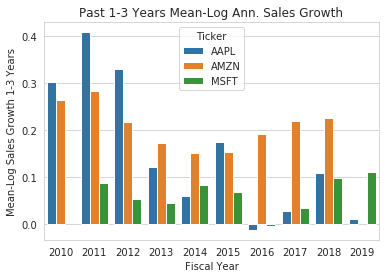

In [59]:
# New column-names.
SALES_GROWTH_1_3Y = 'Mean-Log Sales Growth 1-3 Years'
EARNINGS_GROWTH_1_3Y = 'Mean-Log Earnings Growth 1-3 Years'

# Dict mapping from old to new column-names.
new_names = {REVENUE: SALES_GROWTH_1_3Y,
             NET_INCOME: EARNINGS_GROWTH_1_3Y}

# Calculate mean-log ann. growth-rates for all 1-3 year periods.
df_growth = sf.mean_log_change(df=df, freq='y',
                               future=False, annualized=True,
                               min_years=1, max_years=3,
                               new_names=new_names)

# Remove rows where ALL items are NaN.
# This keeps the rows where e.g. the Revenue growth was valid,
# but the Net Income growth was invalid due to negative numbers.
df_growth = df_growth.dropna(how='all')

# Title of the plot.
title = 'Past 1-3 Years Mean-Log Ann. Sales Growth'

# Plot bar-lines.
sns.barplot(x=FISCAL_YEAR, y=SALES_GROWTH_1_3Y, hue=TICKER,
            data=df_growth.reset_index()).set_title(title)

## Disk Cache

We only used 3 stocks in the examples above, so the stock-returns were calculated very quickly. But for DataFrames with thousands of stocks and share-prices for a decade or more, the returns can take a while to compute, especially for `sf.mean_log_change`.

Both functions `sf_rel_change` and `sf.mean_log_change` can automatically save the results in a cache-file, so the next time you call the function, it first checks if the cache-file exists and is recent enough, and then it loads the DataFrame from the cache-file, otherwise it computes the results and saves them in the cache-file for later use.

This is implemented by using a wrapper-function ` @sf.cache` on the signal-functions. You can also use this wrapper on your own functions (see Tutorial 06).

A few things should be noted:

1. The wrapper adds three more arguments to the original function: `cache_name` which allows you to distinguish cache-files from each other. `cache_refresh` which determines if the signal function should be called and the results saved to the cache-file on disk. `cache_format` which is the format of the cache-file. See Tutorial 06 for details.

2. Because of the new function arguments, you **MUST** use keyword arguments when calling the functions `sf.rel_change` and `sf.mean_log_change`, otherwise you will get an exception (see Tutorial 06 for an explanation).

Here is how we can use the caching-feature with `sf.mean_log_change`. First we need to set a name for the cache, and determine how often it should be refreshed:

In [60]:
# Refresh the cache once a day.
cache_refresh_days = 1

# Name for the cache. Use the concatenated tickers.
cache_name = '-'.join(tickers) + '-1-3y'

# Dict with the cache-arguments. This makes it easier
# to pass the arguments to multiple functions.
cache_args = {'cache_name': cache_name,
              'cache_refresh' : cache_refresh_days}

Now we may call `sf.mean_log_change(..., **cache_args)` which unpacks the arguments in the dict as if they were normal arguments passed to the function. Because the function gets the argument `cache_refresh` it automatically enables the caching feature.

In [61]:
%%time
df_mean_chg = sf.mean_log_change(df=df_prices, freq='bdays',
                                 future=True, annualized=True,
                                 min_years=1, max_years=3,
                                 new_names=new_names_1_3y,
                                 **cache_args)

Cache-file 'mean_log_change-AAPL-AMZN-MSFT-1-3y.pickle' not on disk.
- Running function mean_log_change() ... Done!
- Saving cache-file to disk ... Done!
CPU times: user 125 ms, sys: 4.26 ms, total: 129 ms
Wall time: 121 ms


Note that the cache's filename is `mean_log_change-AAPL-AMZN-MSFT.pickle` which is constructed from the function's name `mean_log_change`, the cache-name we supplied `AAPL-AMZN-MSFT-1-3y`, and the file-extension `.pickle`. This keeps the cache-files neatly organized on disk, while still allowing us to designate different caches for different calls of the same function.

Because these DataFrames are so small, it is very fast to compute the function and there is no real need for the caching-feature. But for DataFrames with thousands of stocks and a decade of share-price data, it might take a while to calculate the results, while it takes less than a second to load it from the cache-file. So the caching-feature may save you a lot of time.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
